In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [2]:
SEED = 0
PATH_TO_DATA = "../Assn1/Data/x06Simple.csv"
ITERATION_CAP = pow(10, 3)
PERCENT_CHANGE_CAP = pow(2, -23)
LEARN_RATE = pow(10, -2)
random.seed(SEED)

In [3]:
def randomize_sr(sr):
    sr_array = sr.array
    random.shuffle(sr_array)
    return pd.Series(sr_array)

In [4]:
def split_df_to_training_testing(df, fraction):
    length = int(math.ceil(len(df) * fraction))
    return df.iloc[:length], df.iloc[length:]

In [5]:
def standardize_sr(sr, avg, std):
    sr_standardized = sr.apply(lambda x: ((x - avg) / std))
    return sr_standardized

In [6]:
def standardize_first_two_columns_df(df, df_train=None):
    if df_train is not None:
        sr_first = df_train.iloc[:, 0]
        sr_second = df_train.iloc[:, 1]
    else:
        sr_first = df.iloc[:, 0]
        sr_second = df.iloc[:, 1]
    df.iloc[:, 0] = standardize_sr(df.iloc[:, 0], sr_first.mean(), sr_first.std())
    df.iloc[:, 1] = standardize_sr(df.iloc[:, 1], sr_second.mean(), sr_second.std())
    return df

In [7]:
def create_matrix_with_ones_column(df):
    length = len(df)
    ones_l = [1 for _ in range(1, length + 1)]
    matrix = np.matrix([i for i in zip(ones_l, df.iloc[:, 0].tolist(), df.iloc[:, 1].tolist())])
    return matrix

In [8]:
def create_feature_target_matrices(df):
    feat = create_matrix_with_ones_column(df)
    target = np.matrix(df.iloc[:, 2].tolist()).transpose()
    return feat, target

In [9]:
def calculate_theta(x_mat, y_mat):
    a = np.matmul(x_mat.transpose(), x_mat)
    b = np.matmul(x_mat.transpose(), y_mat)
    return np.matmul(np.linalg.inv(a), b)

In [10]:
def get_shuffled_indices(df):
    i = df.index.tolist()
    random.shuffle(i)
    return i

In [11]:
def calculate_rmse(target, calculated):
    error = target - calculated
    df_error = pd.DataFrame(error)
    df_error = df_error.applymap(lambda x: x * x)
    return float(pow(df_error.sum() / len(df_error), 1 / 2))

In [12]:
def print_model_output(theta_mat):
    theta_l = theta_mat.tolist()
    output_str = "y = "
    for each in theta_l:
        if theta_l.index(each) == 0:
            output_str += f"{str(each)[1:-1]}"
        else:
            output_str += f"({str(each)[1:-1]}) . x{theta_l.index(each)}"
        if theta_l.index(each) != len(theta_l) - 1:
            output_str += " + "
    print(output_str)

In [13]:
def create_flat_diagonal(m):
    return np.diagflat(m)

In [14]:
def calculate_weighted_theta(diag_weight_mat):
    x_transpose = training_x_matrix.transpose()
    a = np.matmul(x_transpose, diag_weight_mat)
    b = np.matmul(a, training_x_matrix)
    inv = np.linalg.inv(b)
    c = np.matmul(inv, x_transpose)
    d = np.matmul(c, diag_weight_mat)
    e = np.matmul(d, training_y_matrix)
    # b = inverse * training_x_matrix.transpose() * diag * training_y_matrix
    return e

In [15]:
def calculated_weighted_target(y_mat, weigh_theta):
    res = np.matmul(y_mat, weigh_theta)
    return res

In [16]:
def calculate_se(actual, target):
    error = float(actual) - float(target)
    sqr = error * error
    return sqr

In [17]:
def calculate_weighted_rmse(df_test, df_train, df_target_actual):
    row_count = 0
    sum_se = 0
    for _, test_val in df_test.iterrows():
        weight_mat = []
        for _, train_val in df_train.iterrows():
            a = pow((train_val[1] - test_val[1]), 2) + pow((train_val[2] - test_val[2]), 2)
            w = math.exp(-a)
            weight_mat.append(w)
        diagonal_mat = create_flat_diagonal(weight_mat)
        theta_mat = calculate_weighted_theta(diagonal_mat)
        test_mat = np.matrix(test_val)
        weighted_target = calculated_weighted_target(test_mat, theta_mat)
        error = calculate_se(df_target_actual.iloc[row_count], weighted_target)
        sum_se += error
        row_count += 1
    return sum_se

In [18]:
def get_feature_count(df):
    return len(df.columns)

In [19]:
def generate_initial_random_theta(feature_count):
    mat_l = []
    for _ in range(0, feature_count):
        mat_l.append(random.uniform(-1.0, 1.0))
    return np.matrix(mat_l).transpose()

In [20]:
def calculate_gradient(x_mat, y_mat, t):
    a = np.matmul(x_mat, t)
    b = a - y_mat
    grad = 2 * np.matmul(x_mat.transpose(), b)
    # d = np.matmul(2*LEARN_RATE/len(x_mat), c)
    return grad

In [21]:
def calculate_target(df_x, t):
    res_l = []
    for _, row in df_x.iterrows():
        res = np.matrix(row) * t
        res_l.append(float(res))
    return pd.DataFrame(res_l)

In [22]:
def calculate_rmse_from_df(df_y, df_target):
    se_sum = 0
    for (_, y), (_, target) in zip(df_y.iterrows(), df_target.iterrows()):
        diff = calculate_se(y, target)
        se_sum += diff
    mse = se_sum/len(df_y)
    rmse = math.sqrt(mse)
    # diff = df_y - df_target
    # sum = diff.sum()
    # rmse = math.sqrt(float(sum)**2/(len(df_y)-1))
    return rmse

In [23]:
def hit_termination_criteria(cur, old, row_count):
    if (abs(cur - old) <= PERCENT_CHANGE_CAP) or (row_count >= ITERATION_CAP):
        # print("Termination Criteria Met")
        return True
    else:
        return False

In [24]:
def plot_RMSE_graph(training_rmse, testing_rmse):
    plt.plot([i for i in range(0,iter_count + 1)], trainrmse_l, label = "Training")
    plt.plot([i for i in range(0,iter_count + 1)], testrmse_l, label = "Testing")
    plt.legend()
    plt.title('Training RMSE, Testing RMSE v/s Iteration Count')
    plt.xlabel('Iteration Count')
    plt.ylabel('RMSE')
    plt.show()

# Closed Form Linear Regression

In [25]:
df_raw = pd.read_csv(PATH_TO_DATA)
df_no_index = df_raw.drop(axis = 1, labels = 'Index')
indices = get_shuffled_indices(df_no_index)
df_random = df_no_index.iloc[indices].copy().reset_index(drop = True)
df_training, df_testing = split_df_to_training_testing(df_random, 2 / 3)
df_training_standardized = standardize_first_two_columns_df(df_training.copy())
df_testing_standardized = standardize_first_two_columns_df(df_testing.copy(), df_training)
training_x_matrix, training_y_matrix = create_feature_target_matrices(df_training_standardized)
theta = calculate_theta(training_x_matrix, training_y_matrix)
testing_x_matrix, testing_y_matrix = create_feature_target_matrices(df_testing_standardized)
calculated_target = np.matmul(testing_x_matrix, theta)
rmse = calculate_rmse(testing_y_matrix, calculated_target)
print("Linear Regression")
print_model_output(theta)
print(f"RMSE: {rmse}", end = '\n\n')

Linear Regression
y = 2954.0333333333333 + (1164.9010215209619) . x1 + (-286.26664639558896) . x2
RMSE: 537.5342042992407



# Locally-Weighted Linear Regression

In [26]:
df_test_x = pd.DataFrame(testing_x_matrix)
df_test_y = pd.DataFrame(testing_y_matrix)
df_train_x = pd.DataFrame(training_x_matrix)
df_train_y = pd.DataFrame(training_y_matrix)
error_sum = calculate_weighted_rmse(df_test_x, df_train_x, df_test_y)
weighted_rmse = math.sqrt(error_sum / len(df_test_y))
print("Locally Weighted Regression")
print(f'Weighted RMSE: {weighted_rmse}', end='\n\n')

Locally Weighted Regression
Weighted RMSE: 446.2254074923461



# Gradient Descent

Gradient Descent
y = 2954.032064236301 + (1164.8993402646013) . x1 + (-286.26532246327565) . x2
RMSE: 537.5346641815303 after 15 iterations



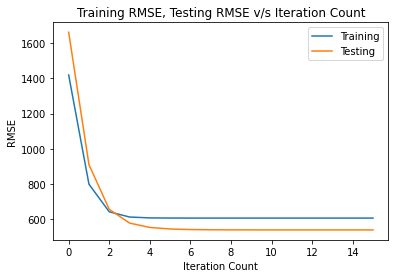

In [27]:
num_features = get_feature_count(df_training)
init_theta = generate_initial_random_theta(num_features)
init_target = calculate_target(df_train_x, init_theta)
old_rmse = calculate_rmse_from_df(df_train_y, init_target)
cur_theta = init_theta.copy()
iter_count = 0
trainrmse_l = []
testrmse_l = []
for row_num in range(0, ITERATION_CAP):
    gradient = calculate_gradient(training_x_matrix, training_y_matrix, cur_theta)
    cur_theta = cur_theta - (LEARN_RATE * gradient)

    calculated_test_target = calculate_target(df_test_x, cur_theta)
    test_rmse = calculate_rmse_from_df(df_test_y, calculated_test_target)

    calculated_train_target = calculate_target(df_train_x, cur_theta)
    cur_rmse = calculate_rmse_from_df(df_train_y, calculated_train_target)
    
    trainrmse_l.append(cur_rmse)
    testrmse_l.append(test_rmse)
    # print(f"Training RMSE: {cur_rmse} @ {row_num}\nTesting RMSE: {test_rmse} @ {row_num}\n")
    if hit_termination_criteria(cur_rmse, old_rmse, row_num):
        break
    else:
        old_rmse = cur_rmse
        iter_count+=1
print("Gradient Descent")
print_model_output(cur_theta)
print(f"RMSE: {test_rmse} after {iter_count} iterations", end = '\n\n')
plot_RMSE_graph(trainrmse_l, testrmse_l)